# CNeuromod Mario Tutorial

## Complete Analysis Pipeline: From GLM to Brain Encoding

<br>

**This series of notebooks covers:**
- Dataset organization and behavioral annotations
- GLM analysis: Actions and game events
- RL agent: Learning representations from gameplay
- Brain encoding: Predicting fMRI from learned features

<br>

---

*Yann Harel @ MAIN Educational 2025*
<div align="center">
  <img src="../images/logos/logo_neuromod_black.png" alt="CNeuromod Logo" width="500"/>
</div>


# Part 0: Dataset Organization and Behavioral Annotations

# Introduction

In [1]:
# @title Environment Setup
# @markdown Run this cell to set up the environment.

import sys
from pathlib import Path

# Step 1: Detect environment and clone repo if needed
try:
    import google.colab
    IN_COLAB = True
    print("☁️  Detected Google Colab environment")
    
    # Clone the repository if not already present
    if not Path("mario.tutorials").exists():
        print("📥 Cloning mario.tutorials repository...")
        import subprocess
        subprocess.run(["git", "clone", "https://github.com/courtois-neuromod/mario.tutorials"], check=True)
    
    # Change to repo directory and add src to path
    import os
    os.chdir("mario.tutorials")
    sys.path.insert(0, str(Path.cwd() / "src"))
    PROJECT_PATH = Path.cwd()
    print(f"✅ Repository ready at: {PROJECT_PATH}")
    
except ImportError:
    # Not in Colab - local environment
    IN_COLAB = False
    print("💻 Detected Local Environment.")
    
    # Adjust path if running from notebooks directory
    if Path.cwd().name == 'notebooks':
        import os
        os.chdir(Path.cwd().parent)
    
    sys.path.insert(0, str(Path.cwd() / "src"))
    PROJECT_PATH = Path.cwd()
    print(f"✅ Working directory: {PROJECT_PATH}")

# Step 2: Import and run setup utilities
from utils import setup_environment, install_dependencies

# Verify/update paths and install dependencies
PROJECT_PATH, IN_COLAB = setup_environment()
install_dependencies("notebooks/00_requirements.txt")

print("\n✅ Setup complete!")

💻 Detected Local Environment.
✅ Ready. Working directory: /home/hyruuk/GitHub/neuromod/mario_analysis/mario.tutorials


## 📊 What is CNeuromod?

**The Courtois Project on Neural Modelling (CNeuromod)** is an open deep phenotyping dataset to build individual models of the brain.

- **5 subjects** scanned extensively (200+ hours each)
- **Multiple paradigms:** Movies, video games, cognitive tasks
- **Deep phenotyping:** Anatomical, functional, behavioral data, several brain modalities
- **Fully open:** Data and code publicly available, collaborative mindset

---

- https://www.cneuromod.ca/
- https://docs.cneuromod.ca/en/latest/
- https://github.com/courtois-neuromod/

## 🎮 CNeuromod Mario: Playing Super Mario Bros in the Scanner

**Why play videogames in a scanner ?**
- Active naturalistic paradigms, well-controled
- Engaging task, warrants human compliance
- Common ground for humans and AI

<br>

**And why Super Mario Bros. ?**
- Objectively good game, many sequels
- Simple but rich gameplay
- Active players and modders communities
- "Easy" for humans, challenging for AIs


## 🍄 Dataset overview

**5 participants** playing Super Mario Bros. (Nintendo, 1983) via [gym-retro](https://github.com/Farama-Foundation/stable-retro)

About **84h** of total combined gameplay

**22 levels**, excluded Waterworld and Bowser castle

**Discovery phase**: complete levels sequentially  
**Practice phase**: play levels in random order

---

#### Data modalities

- **Functional MRI:** Accelerated simultaneous multi-slice (SMS) gradient echo-planar imaging, 2mm isotropic voxels, TR=1.49s
- **Anatomical MRI:** T1-weighted MPRAGE, T2-weighted FSE, Diffusion-weighted (acquired separately)
- **Physiological:** Plethysmography, skin conductance, ECG, respiration, eye-tracking
- **Behavioral:** Frame-by-frame gameplay (60Hz), controller inputs, and event logs


## 📁 This Notebook Covers


**1. Dataset Management**

**2. Rich Behavioral Annotations**

**3. Descriptive Statistics**

---

*Let's dive into the data! 🚀*

## 1. Dataset management

### BIDS Data Organization

**Brain Imaging Data Structure (BIDS)** is a standardized format for organizing neuroimaging data.

**Core principles:**
- Consistent file naming: `sub-<ID>_ses-<N>_task-<name>_run-<N>_<type>.nii.gz`
- Predictable folder hierarchy: `sub-XX/ses-YY/func/`
- Works automatically with analysis tools (fMRIPrep, etc.)
- Easy to share and understand

### Where to Find What You Need

The Mario dataset follows the **Brain Imaging Data Structure (BIDS)** standard:

```
sourcedata/
├── mario/                           # Raw BIDS dataset
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── func/
│               ├── *_events.tsv     # Basic event timing
│               ├── *_bold.nii.gz    # Raw functional scans
│               └── ...
│
├── mario.fmriprep/                  # Preprocessed BOLD data
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── func/
│               ├── *_desc-preproc_bold.nii.gz      # Preprocessed BOLD
│               ├── *_desc-brain_mask.nii.gz        # Brain mask
│               ├── *_desc-confounds_timeseries.tsv # Motion/physio confounds
│               └── ...
│
├── mario.annotations/               # Rich behavioral annotations
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── func/
│               └── *_desc-annotated_events.tsv     # Actions + game events
│
├── mario.replays/                   # Frame-by-frame gameplay data
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── beh/
│               ├── confs/*.npy      # Low-level features (luminance, etc.)
│               ├── infos/*.json     # Metadata: duration, cleared, phase
│               ├── ramdumps/        # Raw emulator state
│               ├── variables/       # Game state variables
│               └── videos/*.mp4     # Full gameplay video
│
├── mario.scenes/                    # Level segmentation and scene-based events
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── beh/
│               ├── infos/*.json        # Scene metadata and clip info
│               ├── videos/*.mp4        # Video clips of the scenes
│               └── ...
│
└── cneuromod.processed/             # Anatomical templates
    └── smriprep/
        └── sub-{01,02,03,05,06}/
            └── anat/
                ├── *_MNI152NLin2009cAsym_preproc.nii.gz  # T1w in MNI space
                └── ...
```

**Key Files for Analysis:**

| Data Type | Location | Use Case |
|-----------|----------|----------|
| **Preprocessed BOLD** | `mario.fmriprep/*/*/func/*_desc-preproc_bold.nii.gz` | GLM, encoding models |
| **Brain mask** | `mario.fmriprep/*/*/func/*_desc-brain_mask.nii.gz` | Restrict analysis to brain |
| **Confounds** | `mario.fmriprep/*/*/func/*_desc-confounds_timeseries.tsv` | Motion/physiology regressors |
| **Rich annotated events** | `mario.annotations/*/*/func/*_desc-annotated_events.tsv` | Button presses, game events |
| **Replay metadata** | `mario.replays/*/*/beh/infos/*.json` | Success/failure, duration, phase |
| **Replay video clips** | `mario.replays/*/*/beh/videos/*.mp4` | Visualizing gameplay |
| **Scene metadata** | `mario.scenes/*/*/beh/infos/*.json` | Scene timing, level, and clip details |
| **Scene video clips** | `mario.scenes/*/*/beh/videos/*.mp4` | Visualizing specific scenes |
| **Low-level features** | `mario.replays/*/*/beh/confs/*.npy` | Luminance, optical flow, audio |
| **Anatomical** | `cneuromod.processed/smriprep/*/anat/*_MNI*.nii.gz` | Registration, visualization |

### Download with DataLad
To ensure reproducibility and manage large datasets efficiently, we use **DataLad**.

**The Setup Process in Shell (terminal):**
1. **Install datasets with** `datalad install`
   - Raw BIDS: `datalad install https://github.com/courtois-neuromod/mario/`
   - Annotations: `datalad install https://github.com/courtois-neuromod/mario.annotations`
   - Replays: `datalad install https://github.com/courtois-neuromod/mario.replays`
   
2. **Fetch the data** with `datalad get`
   - Whole dataset: `datalad get mario/*`
   - Only one subject: `datalad get mario/sub-01/*`
   - Only one type of files: `datalad get mario/sub-01/ses-*/func/*.tsv`

---

... or use Python 🐍

In [2]:
# Download mario.replays with DataLad (if needed)
from pathlib import Path
import subprocess
import json
import pandas as pd

sourcedata_path = Path("./sourcedata")
replays_path = sourcedata_path / "mario.replays"

# Check if data exists
replays_exists = replays_path.exists() and len(list(replays_path.glob("sub-*/ses-*/beh/infos/*.json"))) > 0

if replays_exists:
    print("✓ mario.replays data already downloaded!")
else:
    print("📥 Installing mario.replays with DataLad...")
    
    # Install dataset
    if not replays_path.exists():
        subprocess.run(["datalad", "install", "-s", "https://github.com/courtois-neuromod/mario.replays", str(replays_path)], check=True)
    
    # Fetch metadata files (JSON only, not videos/ramdumps)
    print("Fetching replay metadata files...")
    subprocess.run(["datalad", "get", str(replays_path / "sub-*/ses-*/beh/infos/*.json")], check=True)
    
    print("✓ Download complete!")

# Load replay metadata from JSON files
json_files = sorted(replays_path.glob("sub-*/ses-*/beh/infos/*.json"))
print(f"\nFound {len(json_files)} replay metadata files in mario.replays")

# Load all JSONs into a dataframe
all_data = []
for json_file in json_files:
    with open(json_file, 'r') as f:
        data = json.load(f)
        all_data.append(data)

replay_data = pd.DataFrame(all_data)

print(f"Loaded {len(replay_data)} replays from {len(replay_data['Subject'].unique())} subjects")

✓ mario.replays data already downloaded!

Found 3374 replay metadata files in mario.replays
Loaded 3374 replays from 5 subjects


In [3]:
# Constants
SUBJECT = 'sub-01'
SESSION = 'ses-010'

In [4]:
# Define constants and load annotated events
import pandas as pd
from pathlib import Path

# Load annotated events from mario.annotations
annotations_path = Path("./sourcedata/mario.annotations")

# Get all events for this session across all runs
session_events = []
all_events = []
runs = []

events_files = sorted((annotations_path / SUBJECT / SESSION / "func").glob(f"{SUBJECT}_{SESSION}_task-mario_run-*_desc-annotated_events.tsv"))

if events_files:
    for run_file in events_files:
        run_events = pd.read_csv(run_file, sep='\t')
        session_events.append(run_events)
        all_events.append(run_events)
        runs.append(run_file.stem.split('_')[3])  # Extract run number
    
    session_events = pd.concat(session_events, ignore_index=True)
    EVENTS_LOADED = True
    
    print(f"✓ Loaded events for {SUBJECT} {SESSION}")
    print(f"  Total events: {len(session_events)}")
    print(f"  Number of runs: {len(runs)}")
    print(f"  Levels played in this session: {session_events['level'].unique().tolist()}")
else:
    print(f"✗ Events files not found for {SUBJECT} {SESSION}")
    EVENTS_LOADED = False

✓ Loaded events for sub-01 ses-010
  Total events: 3864
  Number of runs: 4
  Levels played in this session: ['w8l1', 'w8l3', 'w1l3', 'w3l1', 'w2l3', 'w4l2', 'w6l3', 'w7l1', 'w1l1', 'w5l3', 'w4l3', 'w4l1', 'w6l1', 'w1l2', 'w6l2', 'w3l3', 'w7l3', 'w5l1', 'w5l2', 'w8l2', 'w3l2', 'w2l1']


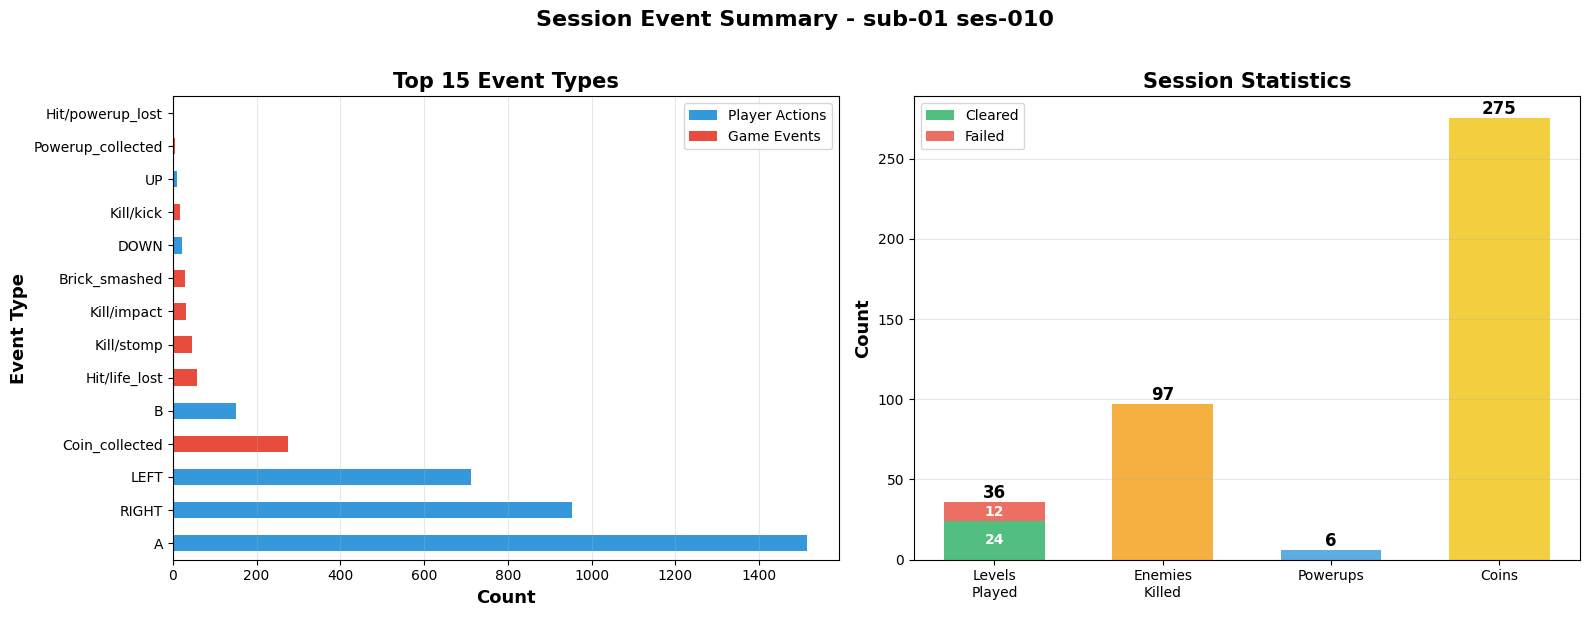

In [5]:
# Visualize event frequencies
import matplotlib.pyplot as plt
from visualization import plot_event_frequencies
import json
from pathlib import Path

# Load replay metadata for this session
replays_path = Path("./sourcedata/mario.replays")
session_replay_path = replays_path / SUBJECT / SESSION / "beh" / "infos"
session_replay_files = sorted(session_replay_path.glob(f"{SUBJECT}_{SESSION}_task-mario_*.json"))

# Load all replay JSONs for this session
session_replays = []
for replay_file in session_replay_files:
    with open(replay_file, 'r') as f:
        session_replays.append(json.load(f))

fig = plot_event_frequencies(
    session_events, session_replays,
    SUBJECT, SESSION
)
plt.show()

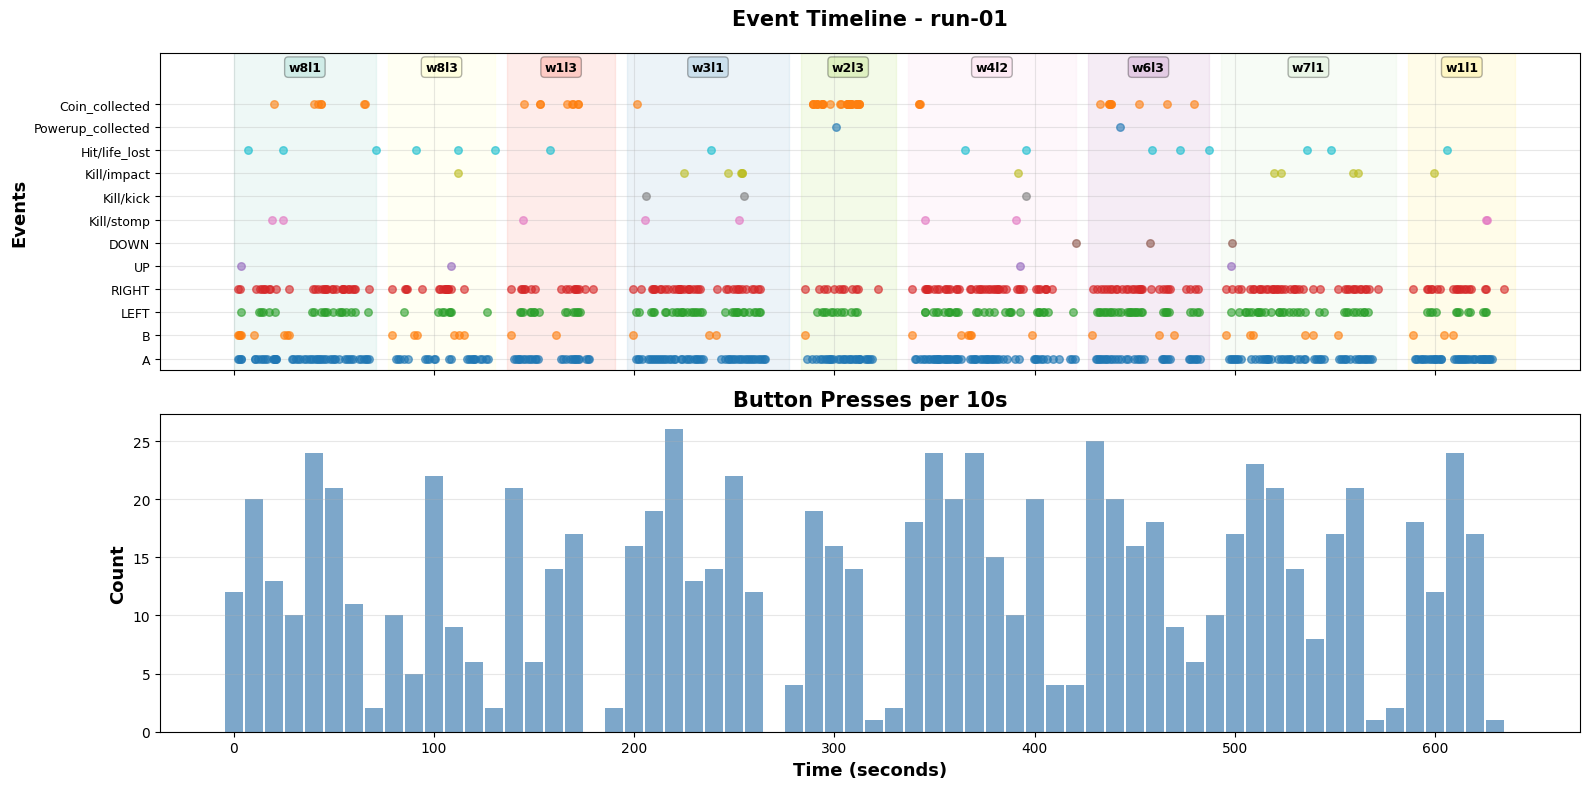

In [6]:
# Event timeline for first run
import matplotlib.pyplot as plt
from visualization import plot_event_timeline

# Define button events for timeline visualization
button_events = ['A', 'B', 'LEFT', 'RIGHT', 'UP', 'DOWN']

if EVENTS_LOADED and len(all_events) > 0:
    # Filter replays for the first run
    run_number = runs[0]  # e.g., 'run-001'
    run_replays = [r for r in session_replays if r.get('Run', '') == run_number]
    
    fig = plot_event_timeline(all_events[0], runs[0], button_events, run_replays=run_replays)
    plt.show()
else:
    print("Timeline not available.")